<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
pip install ucimlrepo

In [23]:
from ucimlrepo import fetch_ucirepo

magic_gamma_telescope = fetch_ucirepo(id=159)

X = magic_gamma_telescope.data.features
y = magic_gamma_telescope.data.targets

data = pd.concat([X, y], axis=1)
names = data.columns.values
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [32]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data['class'].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [33]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [34]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [35]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [36]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

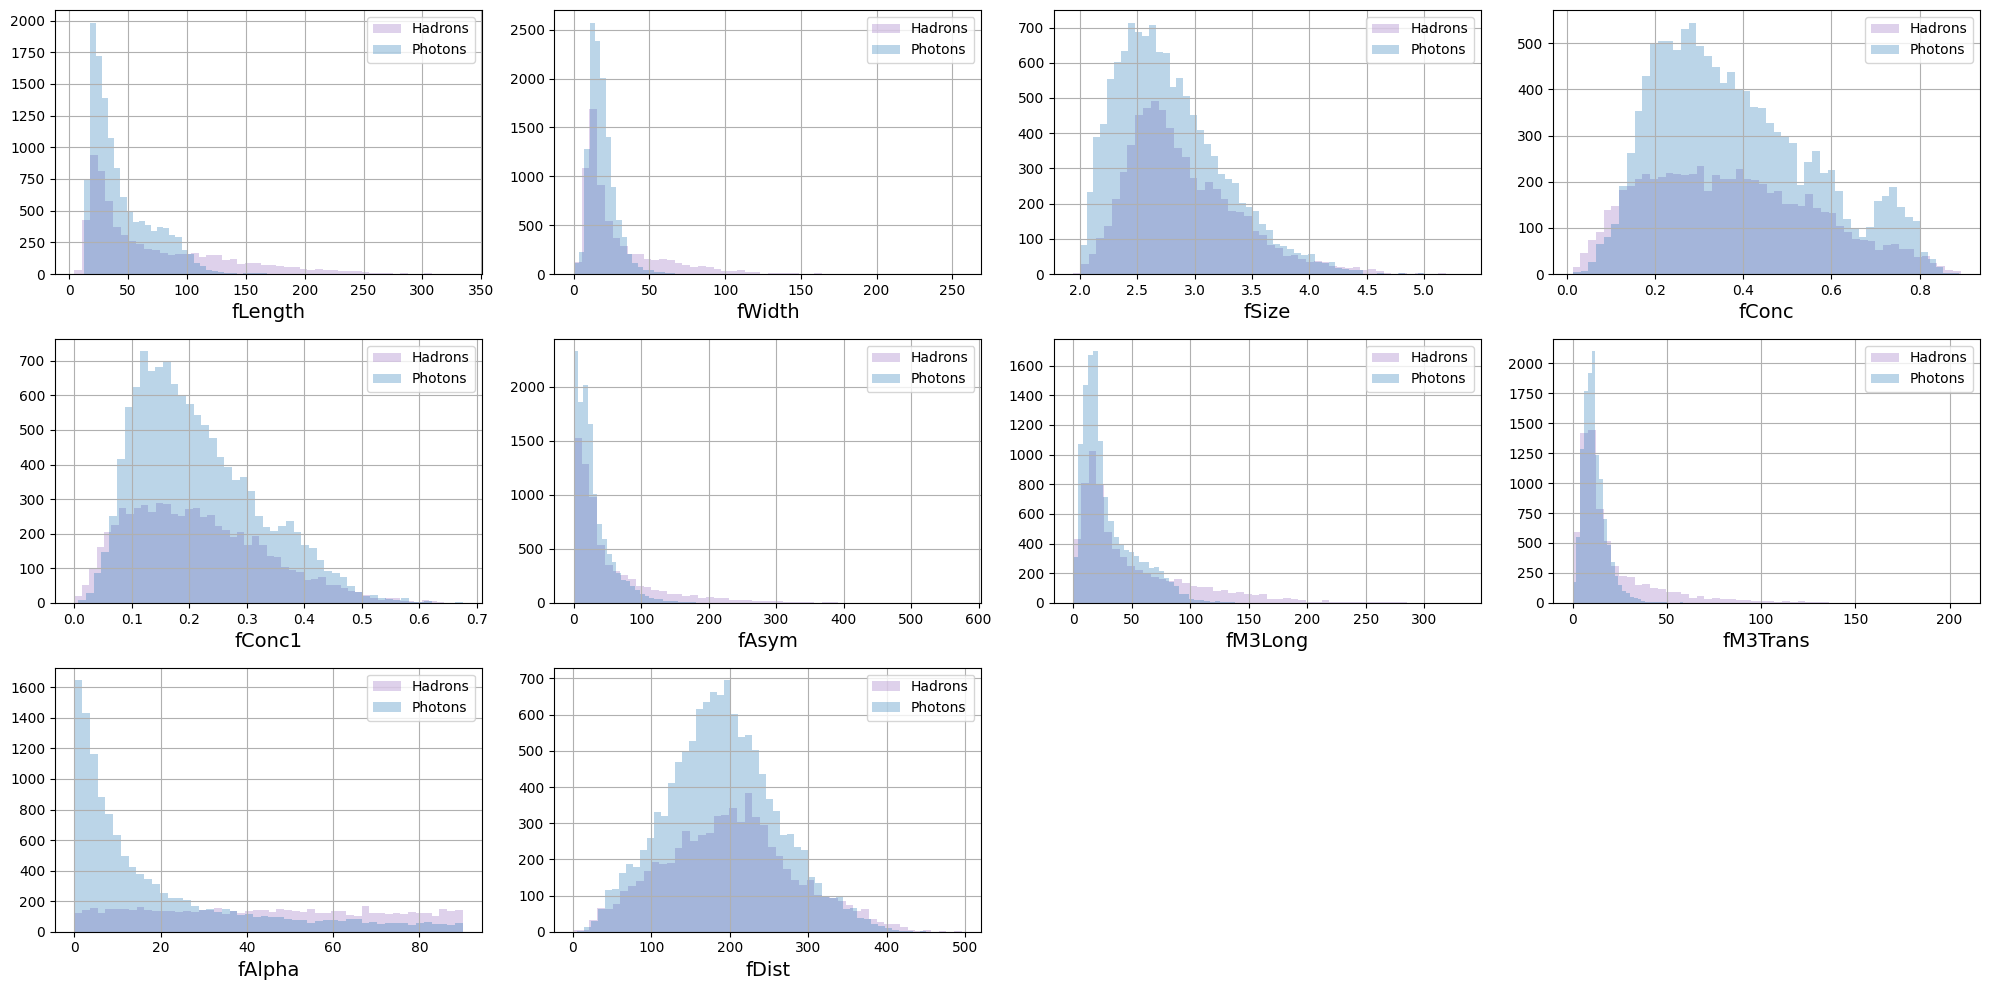

In [38]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [39]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

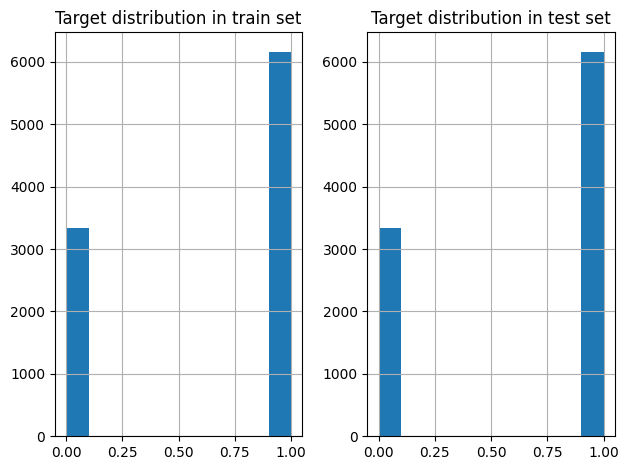

In [41]:
plt.subplot(1, 2, 1)
plt.hist(y_train)
plt.title('Target distribution in train set')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(y_test)
plt.title('Target distribution in test set')
plt.grid()

plt.tight_layout()
plt.show()

Распределение совпадает, потому что в параметрах разделения мы указали `stratify=y`

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [56]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

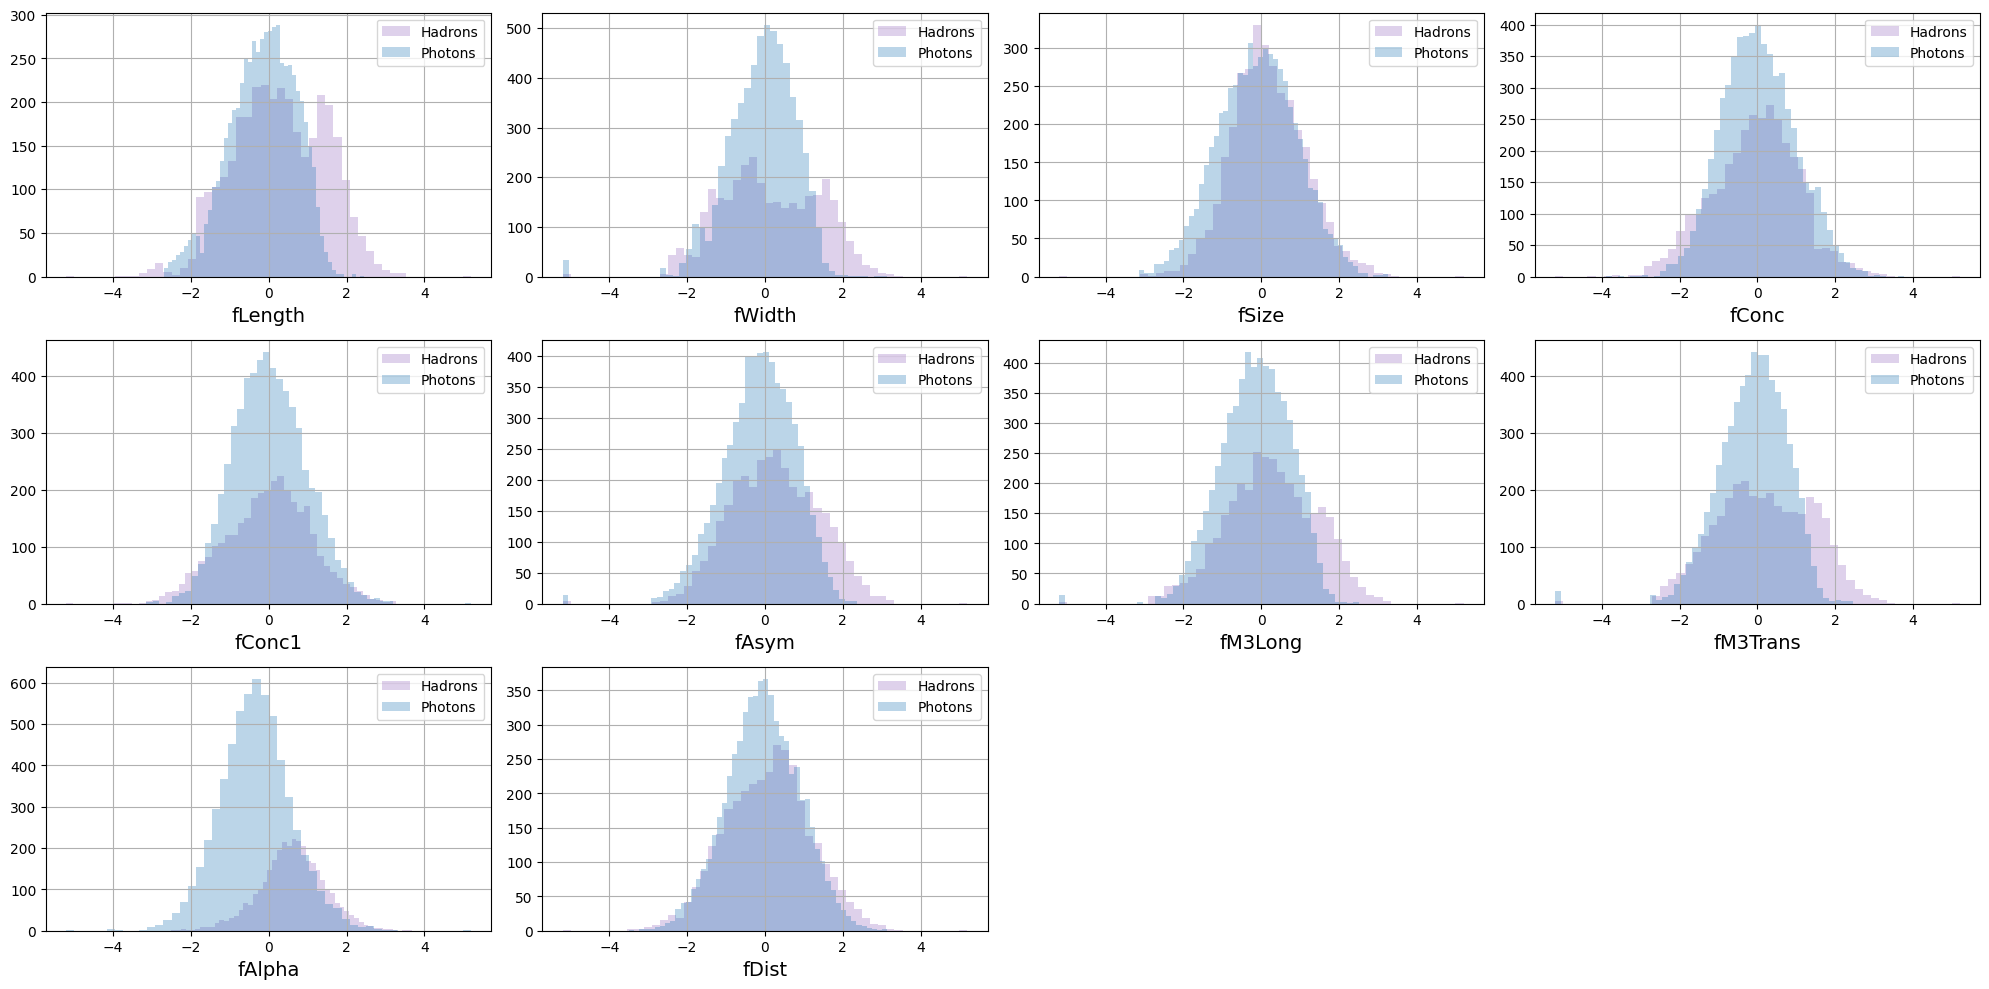

In [43]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

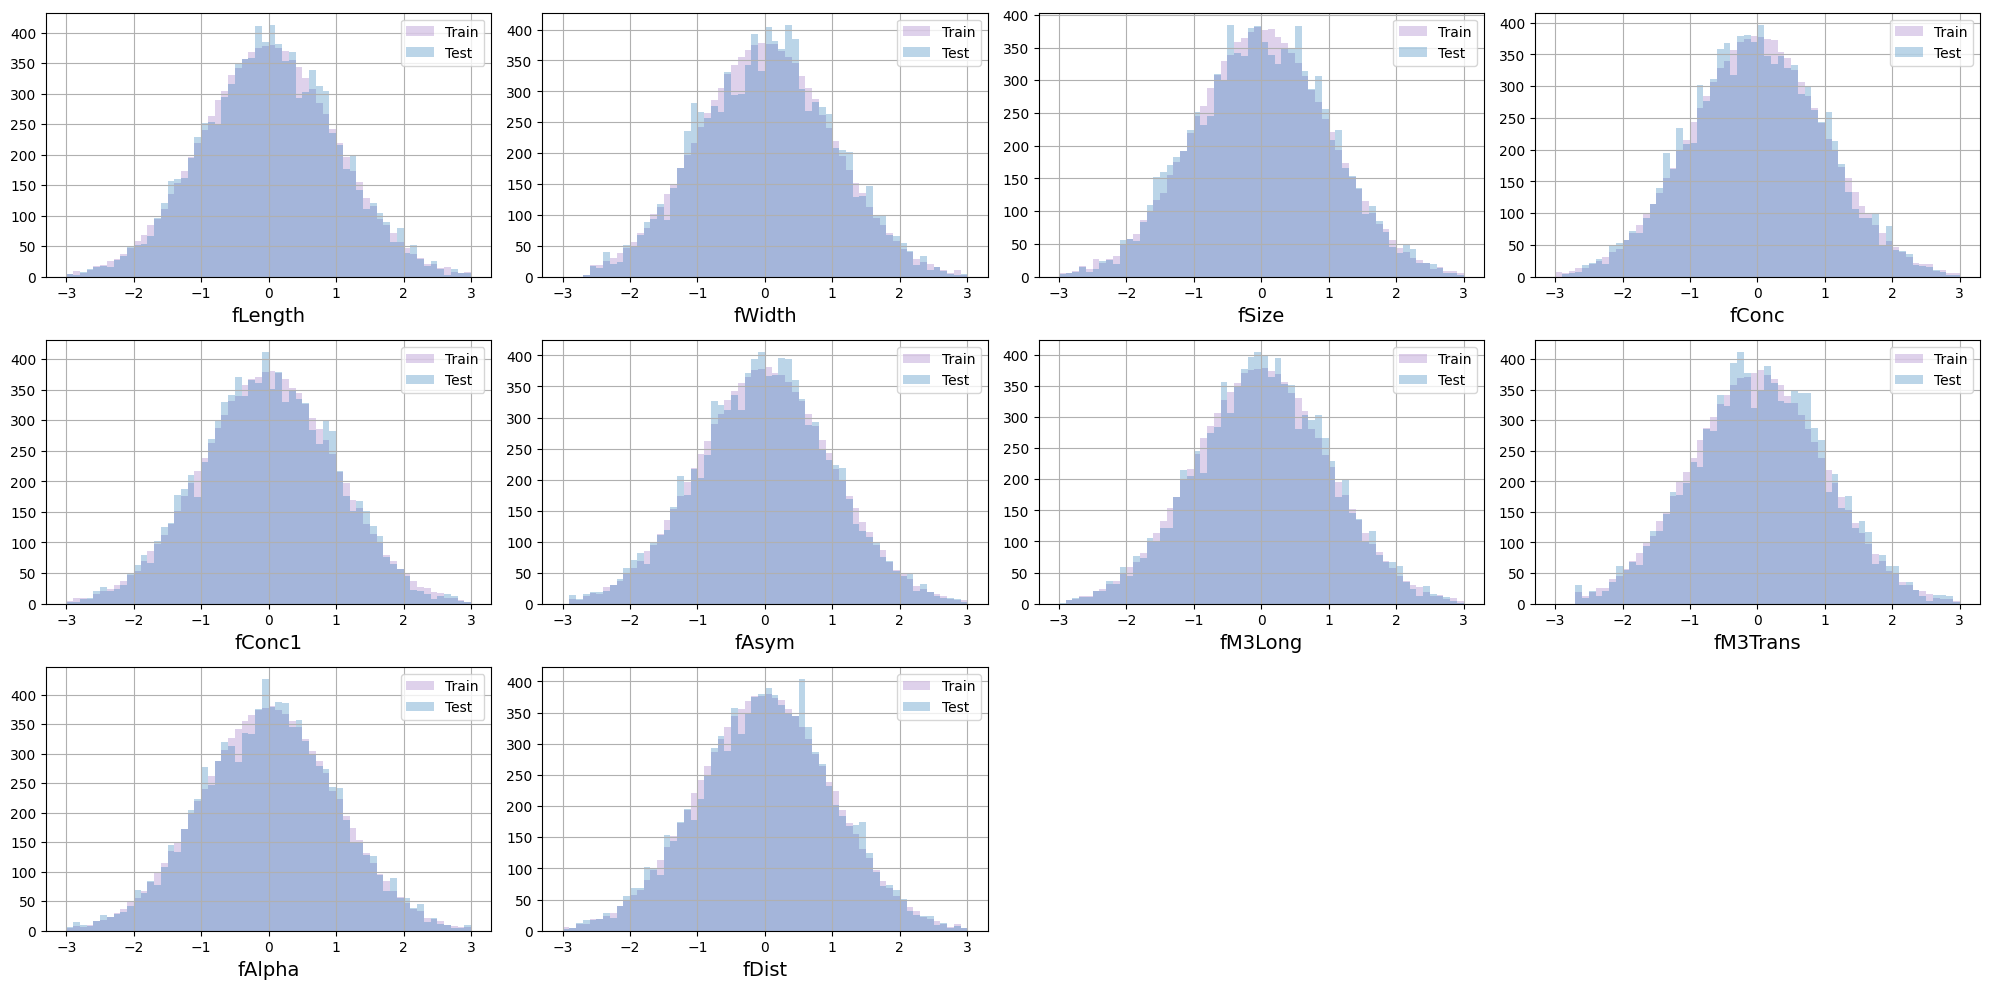

In [44]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [110]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [115]:
def generate(generator, y, latent_dim):
    z = torch.normal(0, 1, (len(y), latent_dim))
    X_fake = generator.forward(z.float(), torch.from_numpy(y).float()).detach().numpy()
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [156]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Можно было бы навесить сигомиду на выход, чтобы получить вероятность принадлежности к классу, но так как WGAN использует расстояние Вассерштейна, здесь сигмоида не нужна

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [49]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X = np.vstack((X_real, X_fake))
    y = np.vstack((y_real, y_fake))
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y, shuffle=True, random_state=153)
    logreg = LogisticRegression()
    boosting = CatBoostClassifier(logging_level='Silent')
    logreg.fit(X_train, y_train)
    boosting.fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, logreg.predict(X_test))
    boosting_score = accuracy_score(y_test, boosting.predict(X_test))
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Нас бы удовлетворило значение accuracy близкое к 0.5, так как тогда классификатор не может отличить сгенерированные картинки от настоящих, значит у нас хорошее качество генерации

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [158]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in tqdm(range(self.n_epochs)):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                z = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                fake_batch = self.generator(z, cond_batch)

                if (i % (self.n_critic + 1)) < 1:
                    self.opt_gen.zero_grad()
                    gen_loss = torch.mean(-self.discriminator(fake_batch, cond_batch))
                    gen_loss.backward()
                    self.opt_gen.step()
                else:
                    self.opt_disc.zero_grad()
                    discr_loss = torch.mean(-self.discriminator(real_batch, cond_batch)) + torch.mean(
                    self.discriminator(fake_batch, cond_batch))
                    discr_loss.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(-self.discriminator(X_real, y_cond)) + torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            index = np.random.choice(X.shape[0], 1000, replace=False)

            x_real = X[index]
            cond = y[index]
            y_real = np.ones_like(cond)
            y_fake = np.zeros_like(cond)
            z_noise = torch.normal(0, 1, (len(x_real), self.latent_dim))
            x_fake = self.generator(z_noise, torch.tensor(cond, dtype=torch.float, device=DEVICE)).detach().numpy()
            other_agent_score(x_real, y_real, x_fake, y_fake)

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [169]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

  1%|          | 1/100 [00:06<11:07,  6.74s/it]

Linear regression score: 0.792
Boosting score: 0.976


  2%|▏         | 2/100 [00:10<08:37,  5.28s/it]

Linear regression score: 0.68
Boosting score: 0.95


  3%|▎         | 3/100 [00:16<08:49,  5.46s/it]

Linear regression score: 0.53
Boosting score: 0.926


  4%|▍         | 4/100 [00:20<07:55,  4.95s/it]

Linear regression score: 0.538
Boosting score: 0.928


  5%|▌         | 5/100 [00:24<07:23,  4.66s/it]

Linear regression score: 0.58
Boosting score: 0.91


  6%|▌         | 6/100 [00:30<07:49,  5.00s/it]

Linear regression score: 0.578
Boosting score: 0.926


  7%|▋         | 7/100 [00:34<07:18,  4.71s/it]

Linear regression score: 0.588
Boosting score: 0.928


  8%|▊         | 8/100 [00:38<06:59,  4.56s/it]

Linear regression score: 0.52
Boosting score: 0.908


  9%|▉         | 9/100 [00:44<07:17,  4.81s/it]

Linear regression score: 0.544
Boosting score: 0.89


 10%|█         | 10/100 [00:48<06:54,  4.60s/it]

Linear regression score: 0.612
Boosting score: 0.886


 11%|█         | 11/100 [00:53<07:07,  4.80s/it]

Linear regression score: 0.578
Boosting score: 0.834


 12%|█▏        | 12/100 [00:58<06:54,  4.71s/it]

Linear regression score: 0.534
Boosting score: 0.836


 13%|█▎        | 13/100 [01:02<06:36,  4.56s/it]

Linear regression score: 0.486
Boosting score: 0.814


 14%|█▍        | 14/100 [01:08<06:59,  4.88s/it]

Linear regression score: 0.548
Boosting score: 0.798


 15%|█▌        | 15/100 [01:12<06:37,  4.68s/it]

Linear regression score: 0.496
Boosting score: 0.834


 16%|█▌        | 16/100 [01:16<06:19,  4.52s/it]

Linear regression score: 0.494
Boosting score: 0.774


 17%|█▋        | 17/100 [01:22<06:45,  4.88s/it]

Linear regression score: 0.48
Boosting score: 0.808


 18%|█▊        | 18/100 [01:26<06:33,  4.80s/it]

Linear regression score: 0.484
Boosting score: 0.788


 19%|█▉        | 19/100 [01:34<07:46,  5.76s/it]

Linear regression score: 0.482
Boosting score: 0.784


 20%|██        | 20/100 [01:38<07:00,  5.26s/it]

Linear regression score: 0.454
Boosting score: 0.788


 21%|██        | 21/100 [01:42<06:28,  4.91s/it]

Linear regression score: 0.506
Boosting score: 0.77


 22%|██▏       | 22/100 [01:48<06:36,  5.08s/it]

Linear regression score: 0.482
Boosting score: 0.778


 23%|██▎       | 23/100 [01:52<06:08,  4.79s/it]

Linear regression score: 0.506
Boosting score: 0.774


 24%|██▍       | 24/100 [01:57<06:06,  4.82s/it]

Linear regression score: 0.508
Boosting score: 0.788


 25%|██▌       | 25/100 [02:01<05:55,  4.74s/it]

Linear regression score: 0.522
Boosting score: 0.79


 26%|██▌       | 26/100 [02:06<05:36,  4.55s/it]

Linear regression score: 0.494
Boosting score: 0.78


 27%|██▋       | 27/100 [02:11<05:55,  4.87s/it]

Linear regression score: 0.504
Boosting score: 0.754


 28%|██▊       | 28/100 [02:15<05:34,  4.65s/it]

Linear regression score: 0.526
Boosting score: 0.772


 29%|██▉       | 29/100 [02:19<05:18,  4.49s/it]

Linear regression score: 0.522
Boosting score: 0.742


 30%|███       | 30/100 [02:25<05:38,  4.84s/it]

Linear regression score: 0.554
Boosting score: 0.77


 31%|███       | 31/100 [02:29<05:17,  4.61s/it]

Linear regression score: 0.504
Boosting score: 0.748


 32%|███▏      | 32/100 [02:33<05:04,  4.47s/it]

Linear regression score: 0.5
Boosting score: 0.746


 33%|███▎      | 33/100 [02:39<05:21,  4.80s/it]

Linear regression score: 0.492
Boosting score: 0.726


 34%|███▍      | 34/100 [02:43<05:03,  4.59s/it]

Linear regression score: 0.494
Boosting score: 0.72


 35%|███▌      | 35/100 [02:48<05:05,  4.71s/it]

Linear regression score: 0.488
Boosting score: 0.708


 36%|███▌      | 36/100 [02:53<04:58,  4.66s/it]

Linear regression score: 0.496
Boosting score: 0.71


 37%|███▋      | 37/100 [02:57<04:43,  4.50s/it]

Linear regression score: 0.48
Boosting score: 0.702


 38%|███▊      | 38/100 [03:02<05:02,  4.89s/it]

Linear regression score: 0.482
Boosting score: 0.69


 39%|███▉      | 39/100 [03:07<04:44,  4.66s/it]

Linear regression score: 0.518
Boosting score: 0.72


 40%|████      | 40/100 [03:11<04:32,  4.53s/it]

Linear regression score: 0.566
Boosting score: 0.708


 41%|████      | 41/100 [03:17<04:48,  4.88s/it]

Linear regression score: 0.49
Boosting score: 0.71


 42%|████▏     | 42/100 [03:21<04:29,  4.65s/it]

Linear regression score: 0.52
Boosting score: 0.702


 43%|████▎     | 43/100 [03:25<04:16,  4.50s/it]

Linear regression score: 0.534
Boosting score: 0.666


 44%|████▍     | 44/100 [03:30<04:26,  4.75s/it]

Linear regression score: 0.478
Boosting score: 0.684


 45%|████▌     | 45/100 [03:34<04:11,  4.58s/it]

Linear regression score: 0.496
Boosting score: 0.67


 46%|████▌     | 46/100 [03:40<04:17,  4.76s/it]

Linear regression score: 0.466
Boosting score: 0.662


 47%|████▋     | 47/100 [03:44<04:06,  4.65s/it]

Linear regression score: 0.5
Boosting score: 0.688


 48%|████▊     | 48/100 [03:48<03:52,  4.48s/it]

Linear regression score: 0.542
Boosting score: 0.692


 49%|████▉     | 49/100 [03:54<04:06,  4.83s/it]

Linear regression score: 0.546
Boosting score: 0.68


 50%|█████     | 50/100 [03:58<03:49,  4.60s/it]

Linear regression score: 0.502
Boosting score: 0.684


 51%|█████     | 51/100 [04:02<03:37,  4.44s/it]

Linear regression score: 0.538
Boosting score: 0.656


 52%|█████▏    | 52/100 [04:07<03:50,  4.81s/it]

Linear regression score: 0.574
Boosting score: 0.676


 53%|█████▎    | 53/100 [04:12<03:37,  4.62s/it]

Linear regression score: 0.534
Boosting score: 0.642


 54%|█████▍    | 54/100 [04:16<03:24,  4.45s/it]

Linear regression score: 0.544
Boosting score: 0.706


 55%|█████▌    | 55/100 [04:21<03:32,  4.73s/it]

Linear regression score: 0.544
Boosting score: 0.624


 56%|█████▌    | 56/100 [04:25<03:19,  4.54s/it]

Linear regression score: 0.538
Boosting score: 0.726


 57%|█████▋    | 57/100 [04:30<03:22,  4.71s/it]

Linear regression score: 0.562
Boosting score: 0.648


 58%|█████▊    | 58/100 [04:35<03:15,  4.65s/it]

Linear regression score: 0.566
Boosting score: 0.668


 59%|█████▉    | 59/100 [04:39<03:05,  4.52s/it]

Linear regression score: 0.526
Boosting score: 0.658


 60%|██████    | 60/100 [04:45<03:16,  4.91s/it]

Linear regression score: 0.494
Boosting score: 0.632


 61%|██████    | 61/100 [04:49<03:05,  4.76s/it]

Linear regression score: 0.512
Boosting score: 0.634


 62%|██████▏   | 62/100 [04:53<02:55,  4.61s/it]

Linear regression score: 0.53
Boosting score: 0.676


 63%|██████▎   | 63/100 [04:59<03:05,  5.01s/it]

Linear regression score: 0.536
Boosting score: 0.63


 64%|██████▍   | 64/100 [05:04<02:54,  4.83s/it]

Linear regression score: 0.496
Boosting score: 0.618


 65%|██████▌   | 65/100 [05:10<03:00,  5.16s/it]

Linear regression score: 0.5
Boosting score: 0.66


 66%|██████▌   | 66/100 [05:14<02:46,  4.90s/it]

Linear regression score: 0.512
Boosting score: 0.632


 67%|██████▋   | 67/100 [05:18<02:35,  4.71s/it]

Linear regression score: 0.534
Boosting score: 0.626


 68%|██████▊   | 68/100 [05:24<02:40,  5.03s/it]

Linear regression score: 0.578
Boosting score: 0.618


 69%|██████▉   | 69/100 [05:28<02:28,  4.80s/it]

Linear regression score: 0.522
Boosting score: 0.602


 70%|███████   | 70/100 [05:33<02:21,  4.70s/it]

Linear regression score: 0.506
Boosting score: 0.612


 71%|███████   | 71/100 [05:38<02:22,  4.90s/it]

Linear regression score: 0.542
Boosting score: 0.582


 72%|███████▏  | 72/100 [05:42<02:11,  4.69s/it]

Linear regression score: 0.562
Boosting score: 0.642


 73%|███████▎  | 73/100 [05:48<02:12,  4.92s/it]

Linear regression score: 0.538
Boosting score: 0.604


 74%|███████▍  | 74/100 [05:52<02:03,  4.74s/it]

Linear regression score: 0.534
Boosting score: 0.64


 75%|███████▌  | 75/100 [05:56<01:54,  4.57s/it]

Linear regression score: 0.506
Boosting score: 0.63


 76%|███████▌  | 76/100 [06:02<01:58,  4.94s/it]

Linear regression score: 0.512
Boosting score: 0.6


 77%|███████▋  | 77/100 [06:06<01:48,  4.72s/it]

Linear regression score: 0.498
Boosting score: 0.596


 78%|███████▊  | 78/100 [06:11<01:40,  4.56s/it]

Linear regression score: 0.588
Boosting score: 0.622


 79%|███████▉  | 79/100 [06:16<01:42,  4.88s/it]

Linear regression score: 0.56
Boosting score: 0.622


 80%|████████  | 80/100 [06:20<01:33,  4.65s/it]

Linear regression score: 0.518
Boosting score: 0.668


 81%|████████  | 81/100 [06:25<01:30,  4.78s/it]

Linear regression score: 0.52
Boosting score: 0.65


 82%|████████▏ | 82/100 [06:30<01:25,  4.76s/it]

Linear regression score: 0.562
Boosting score: 0.638


 83%|████████▎ | 83/100 [06:34<01:18,  4.59s/it]

Linear regression score: 0.482
Boosting score: 0.644


 84%|████████▍ | 84/100 [06:42<01:26,  5.41s/it]

Linear regression score: 0.51
Boosting score: 0.62


 85%|████████▌ | 85/100 [06:48<01:27,  5.86s/it]

Linear regression score: 0.51
Boosting score: 0.596


 86%|████████▌ | 86/100 [06:54<01:21,  5.84s/it]

Linear regression score: 0.518
Boosting score: 0.628


 87%|████████▋ | 87/100 [06:58<01:09,  5.34s/it]

Linear regression score: 0.554
Boosting score: 0.634


 88%|████████▊ | 88/100 [07:03<01:01,  5.09s/it]

Linear regression score: 0.556
Boosting score: 0.644


 89%|████████▉ | 89/100 [07:08<00:56,  5.12s/it]

Linear regression score: 0.576
Boosting score: 0.666


 90%|█████████ | 90/100 [07:12<00:48,  4.85s/it]

Linear regression score: 0.514
Boosting score: 0.606


 91%|█████████ | 91/100 [07:18<00:46,  5.14s/it]

Linear regression score: 0.55
Boosting score: 0.62


 92%|█████████▏| 92/100 [07:22<00:39,  4.88s/it]

Linear regression score: 0.52
Boosting score: 0.62


 93%|█████████▎| 93/100 [07:27<00:32,  4.68s/it]

Linear regression score: 0.516
Boosting score: 0.622


 94%|█████████▍| 94/100 [07:33<00:30,  5.02s/it]

Linear regression score: 0.494
Boosting score: 0.632


 95%|█████████▌| 95/100 [07:37<00:23,  4.77s/it]

Linear regression score: 0.522
Boosting score: 0.606


 96%|█████████▌| 96/100 [07:41<00:18,  4.62s/it]

Linear regression score: 0.526
Boosting score: 0.616


 97%|█████████▋| 97/100 [07:46<00:14,  4.85s/it]

Linear regression score: 0.506
Boosting score: 0.608


 98%|█████████▊| 98/100 [07:51<00:09,  4.67s/it]

Linear regression score: 0.496
Boosting score: 0.624


 99%|█████████▉| 99/100 [07:56<00:04,  4.90s/it]

Linear regression score: 0.55
Boosting score: 0.638


100%|██████████| 100/100 [08:00<00:00,  4.81s/it]

Linear regression score: 0.532
Boosting score: 0.614
CPU times: user 11min 41s, sys: 49.9 s, total: 12min 31s
Wall time: 8min


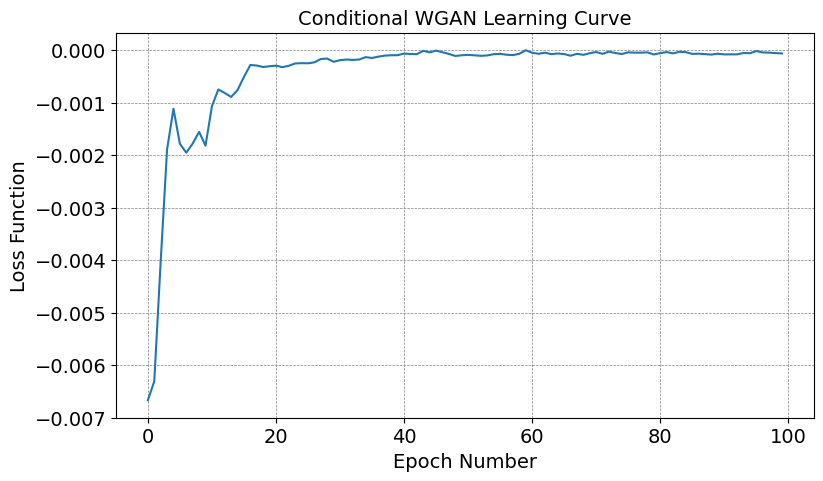

In [170]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [171]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [172]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

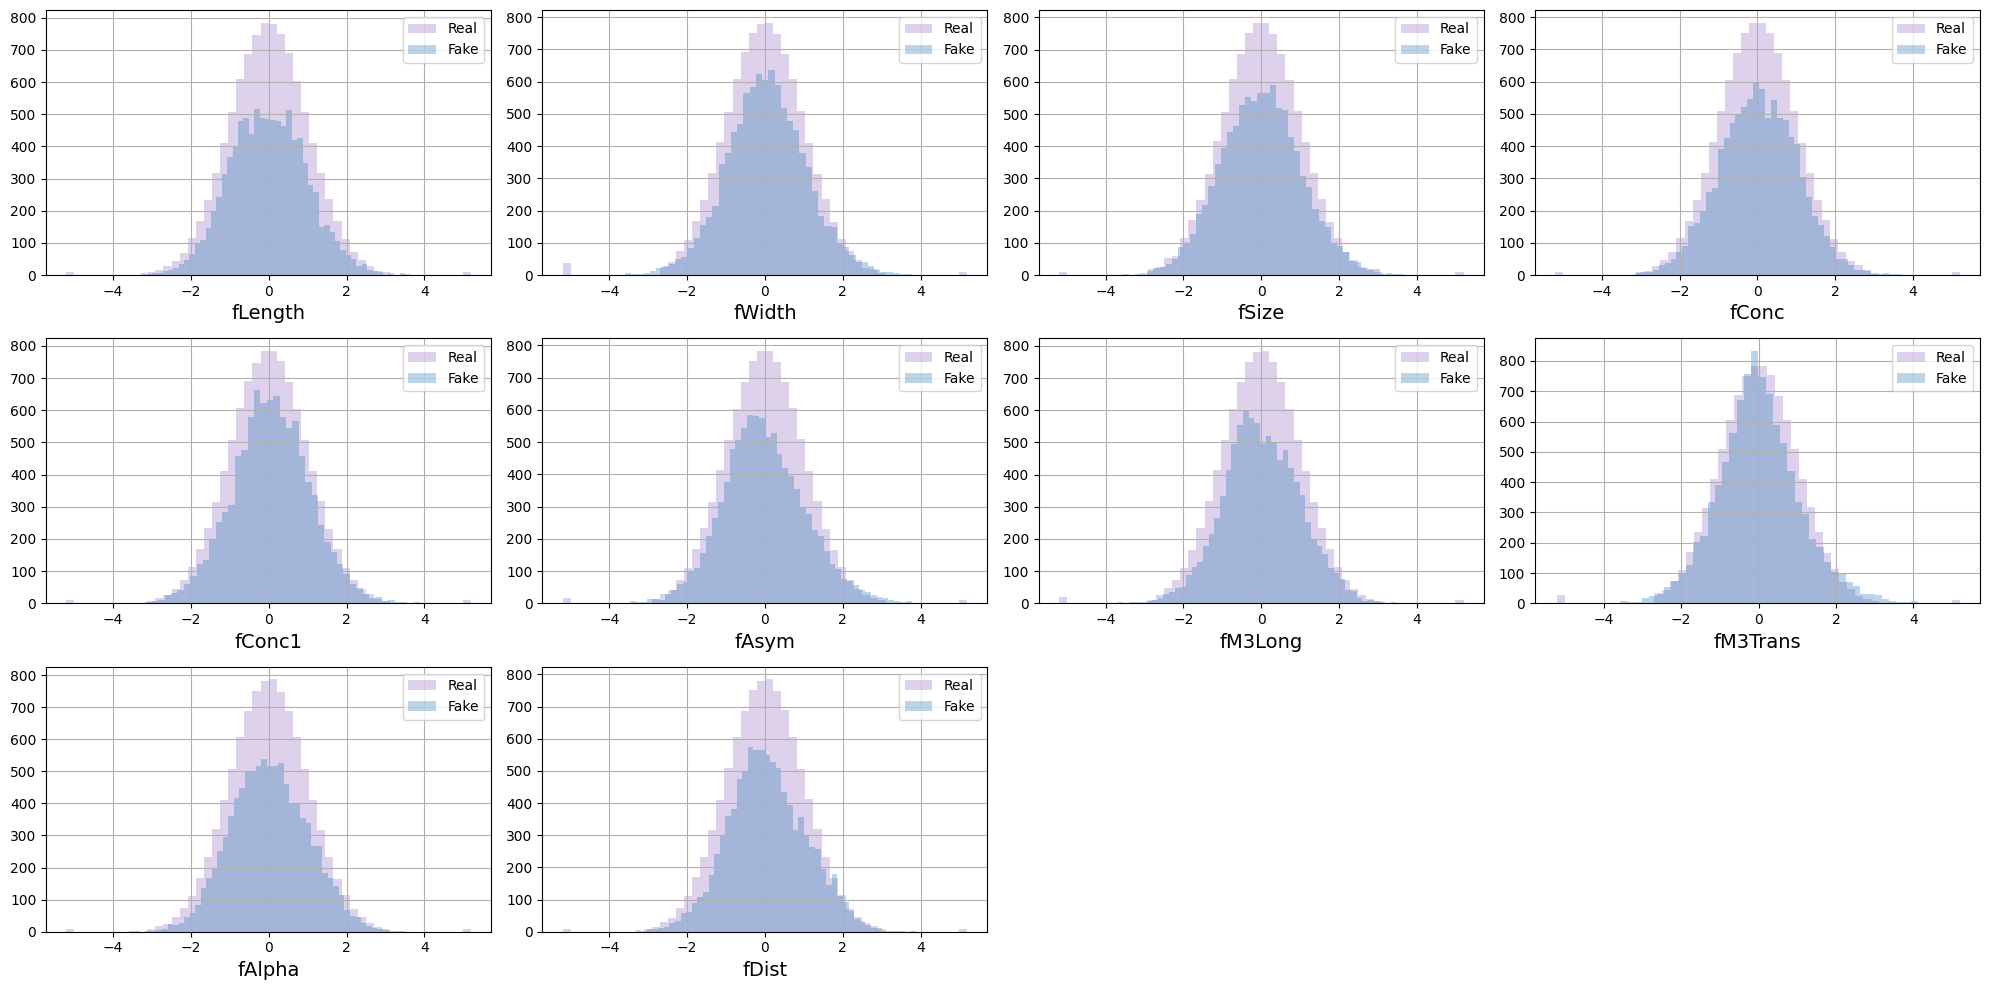

In [173]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [174]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

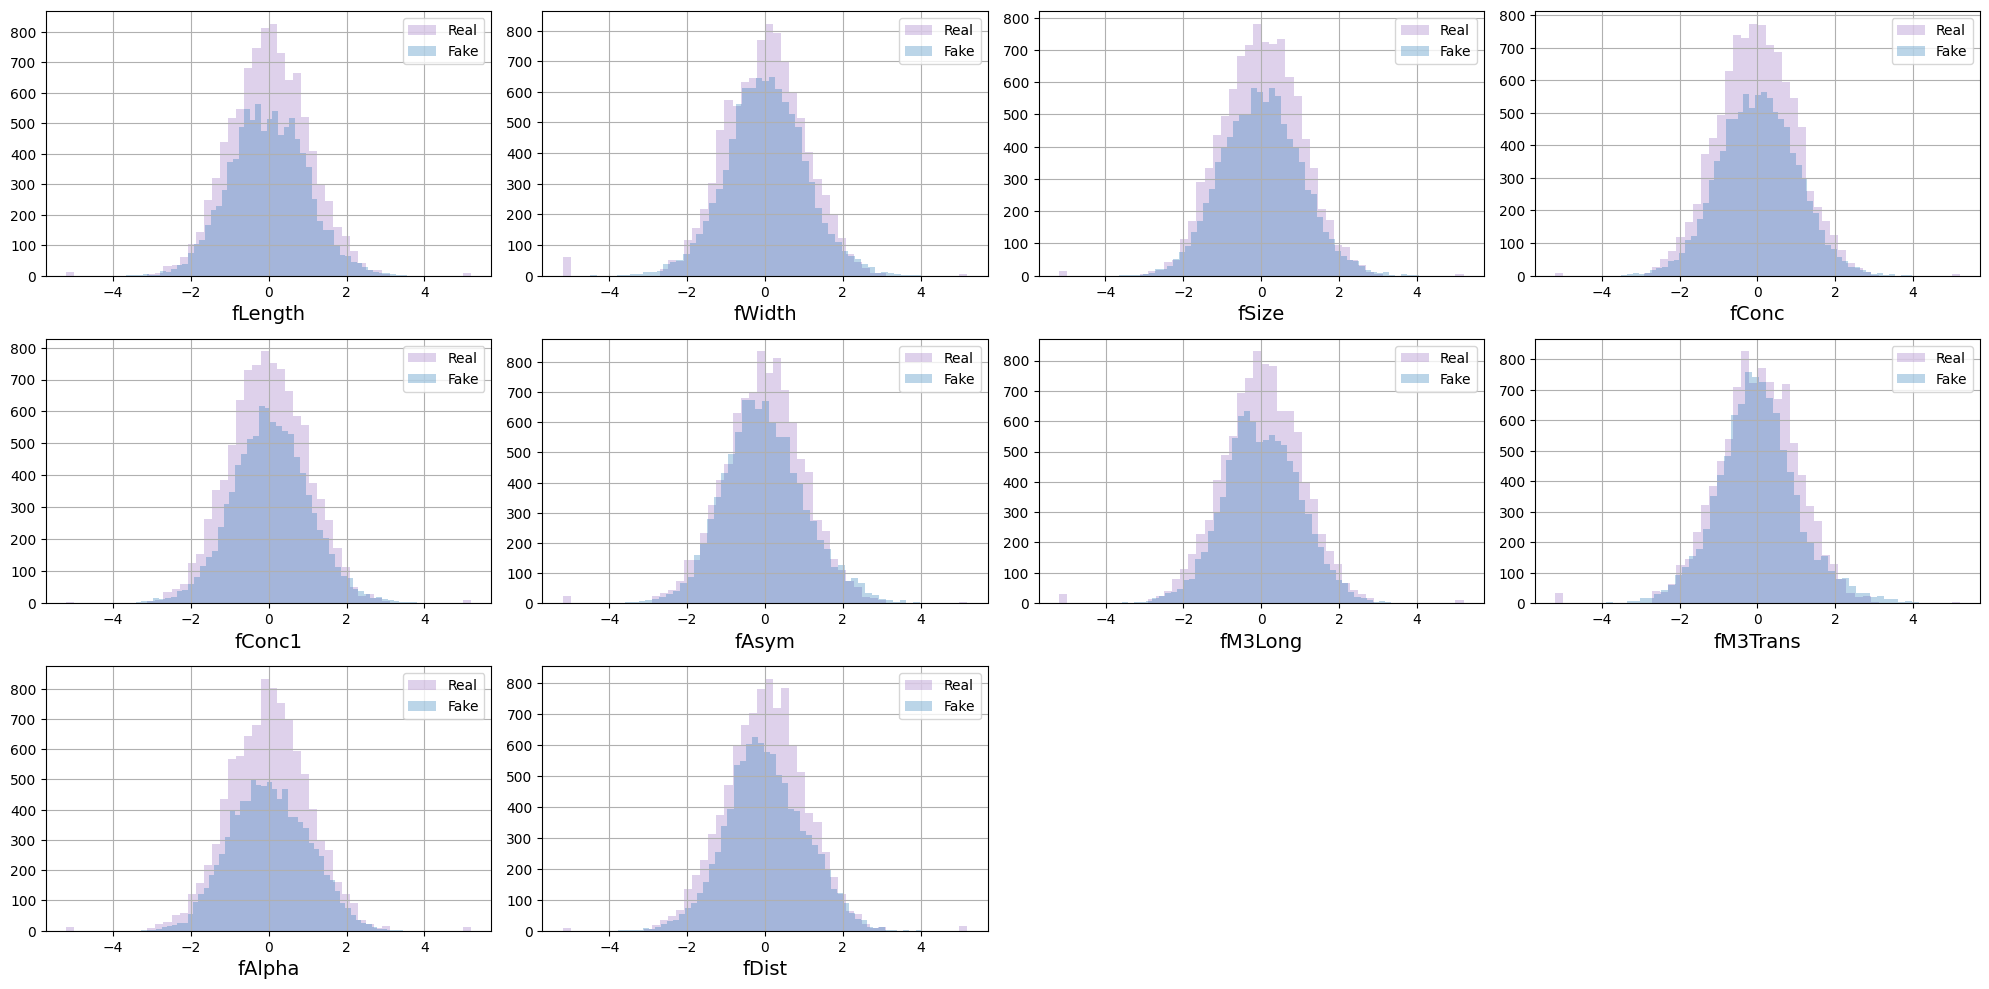

In [175]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы:
- Похожи ли фейковые объекты на реальные?
- Точно ли хорошая идея сравнивать их на глаз?


# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2025/homeworks/HW1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [176]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [177]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [178]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6984722761253028


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = # YOUR CODE HERE
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######

        ### THE END OF YOUR CODE ###

    def forward(self, z, t, y):
        ### YOUR CODE IS HERE ######
        # Склейте z, t и y при помощи torch.cat
        # Подумайте по какому dim это нужно сделать (в качестве подсказки можете посмотреть документацию Linear)
        # А также о том, что t, скорее всего, одно число, а батч у вас будет большой!
        # Либо предусмотрите раздувание t где-то в другом месте
        return ...

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    # Подсказки: вам понадобится .prev_sample после шага scheduler
    # А ещё цикл по таймстепам
    X_fake = ...
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # Подсказки:
                # Подумайте какой шум вам тут нужен (uniform/normal?)
                # Помните про scheduler? Как вариант, можете генерировать случайный вектор из integer
                # И подавать его в add_noise и модель

                ...

                loss_epoch += ...

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            ...
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов.

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ.

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.enc_net = ...

        self.mu = ...
        self.log_sigma = ...
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.dec_net = ...
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

def generate(decoder, y, latent_dim):
    ### YOUR CODE IS HERE ######
    X_fake = ...
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

In [ ]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        ### YOUR CODE IS HERE ######
        loss = ...
        ### THE END OF YOUR CODE ###

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!